<a href="https://colab.research.google.com/github/Nildk123/Deeplearning/blob/master/Week5/Assignment5___Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#de# utility function 1


import numpy as np
from random import randint

def myFunc(input_img,p = 0.2, s_l=0.02, s_h=0.04, r_1=0.3, r_2=1/0.3,v_l=0, v_h=255, pixel_level=False):
    #image = np.array(image)
    x = randint(0,16)
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()
    if p_1 > p:
      return input_img

    while True:
      s = np.random.uniform(s_l, s_h) * img_h * img_w
      r = np.random.uniform(r_1, r_2)
      w = int(np.sqrt(s / r))
      h = int(np.sqrt(s * r))
      left = np.random.randint(0, img_w)
      top = np.random.randint(0, img_h)
      if left + w <= img_w and top + h <= img_h:
        break
    if pixel_level:
      c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
      c = np.random.uniform(v_l, v_h)
    input_img[top:top + h, left:left + w, :] = c
    return(input_img)

In [0]:
import tensorflow as tf
#import tensorflow.contrib.eager as tfe
#tf.enable_eager_execution()

In [0]:
from keras.callbacks import *
#Have taken this class from https://github.com/titu1994/keras-one-cycle
class OneCycleLR(Callback):
    def __init__(self,
                 epochs,
                 batch_size,
                 samples,
                 steps,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = epochs
        self.batch_size = batch_size
        self.samples = samples
        self.steps = steps
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        
        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))


class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):
        """
        This class uses the Cyclic Learning Rate history to find a
        set of learning rates that can be good initializations for the
        One-Cycle training proposed by Leslie Smith in the paper referenced
        below.
        A port of the Fast.ai implementation for Keras.
        # Note
        This requires that the model be trained for exactly 1 epoch. If the model
        is trained for more epochs, then the metric calculations are only done for
        the first epoch.
        # Interpretation
        Upon visualizing the loss plot, check where the loss starts to increase
        rapidly. Choose a learning rate at somewhat prior to the corresponding
        position in the plot for faster convergence. This will be the maximum_lr lr.
        Choose the max value as this value when passing the `max_val` argument
        to OneCycleLR callback.
        Since the plot is in log-scale, you need to compute 10 ^ (-k) of the x-axis
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            minimum_lr: Float. Initial learning rate (and the minimum).
            maximum_lr: Float. Final learning rate (and the maximum).
            lr_scale: Can be one of ['exp', 'linear']. Chooses the type of
                scaling for each update to the learning rate during subsequent
                batches. Choose 'exp' for large range and 'linear' for small range.
            validation_data: Requires the validation dataset as a tuple of
                (X, y) belonging to the validation set. If provided, will use the
                validation set to compute the loss metrics. Else uses the training
                batch loss. Will warn if not provided to alert the user.
            validation_sample_rate: Positive or Negative Integer. Number of batches to sample from the
                validation set per iteration of the LRFinder. Larger number of
                samples will reduce the variance but will take longer time to execute
                per batch.
                If Positive > 0, will sample from the validation dataset
                If Megative, will use the entire dataset
            stopping_criterion_factor: Integer or None. A factor which is used
                to measure large increase in the loss value during training.
                Since callbacks cannot stop training of a model, it will simply
                stop logging the additional values from the epochs after this
                stopping criterion has been met.
                If None, this check will not be performed.
            loss_smoothing_beta: Float. The smoothing factor for the moving
                average of the loss function.
            save_dir: Optional, String. If passed a directory path, the callback
                will save the running loss and learning rates to two separate numpy
                arrays inside this directory. If the directory in this path does not
                exist, they will be created.
            verbose: Whether to print the learning rate after every batch of training.
        # References:
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
        """
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than o")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        # If negative, use entire validation set
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]

            # use 5 random batches from test set for fast approximate of loss
            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']

        # smooth the loss value and bias correct
        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)

        # stop logging if loss is too large
        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)

        # compute the lr for the next batch and update the optimizer lr
        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)

        # save the other metrics as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        """
        Plots the schedule from the callback itself.
        # Arguments:
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        """
        Loads the training history from the saved numpy files in the given directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        Returns:
            tuple of (losses, learning rates)
        """
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):
        """
        Plots the schedule from the saved numpy arrays of the loss and learning
        rate values in the specified directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

In [0]:
# importing packages an dependencies
%tensorflow_version 1.x

import cv2
import json
import os

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization, Activation
from keras.layers import Convolution2D, MaxPooling2D


In [0]:
import os
import zipfile
from skimage import io
import tensorflow as tf

from keras.preprocessing import image
from keras import backend as K
from keras.applications.vgg16 import preprocess_input

In [0]:
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root_dir = "/content/drive/My Drive/EIP/hvc_data/"
os.chdir(root_dir)

In [0]:

df = pd.read_csv("./hvc_annotations.csv")
print(df.shape)

(13573, 10)


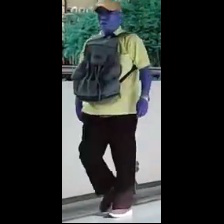

(224, 224, 3)


In [0]:
#display sample images
from google.colab.patches import cv2_imshow
ext_img = io.imread("resized/120.jpg")
cv2_imshow(ext_img)
print(ext_img.shape)



In [0]:
print((ext_img.shape))
data_aug = lambda x: (tf.image.random_flip_left_right(tf.random_crop(x, [8, 8,3])))
#tf.data.Dataset.from_tensor_slices(ext_img).map(data_aug).shape


(224, 224, 3)


In [0]:
#tf.data.Dataset.from_tensor_slices(ext_img).map(data_aug).shape

In [0]:
#tf.data.Dataset.from_tensor_slices(io.imread("resized/1200.jpg")).map(data_aug)
ext_image = io.imread("resized/1200.jpg")
ext_image = tf.image.random_flip_left_right(tf.random_crop(ext_image,[32,32,3]))
print(ext_image.shape)

(32, 32, 3)


In [0]:
tf.random_crop(io.imread("resized/1200.jpg"),[220,220,3]).shape

TensorShape([Dimension(220), Dimension(220), Dimension(3)])

In [0]:
one_hot_df = pd.concat([
                        df[['image_path']],
                        pd.get_dummies(df['gender'], prefix = "gender"),
                        pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose")
                        ], axis = 1)
one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np
import tensorflow as tf

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=16,shuffle=True, augmentation = None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        try:
          batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
          
          items = self.df.iloc[batch_slice]
          #image = np.stack([io.imread(item["image_path"]) for _, item in items.iterrows()])
          #if self.augmentation is not None:
          #  images = self.augmentation.flow(images, shuffle = False)

          image = np.stack([myFunc(io.imread(item["image_path"]), p = 0.5) for _, item in items.iterrows()])
          #print(image.shape)
          '''
          
          print("checking images")
          for _,item in items.iterrows():
            
            imageTemp = io.imread(item["image_path"])
            print("data aug images")
            imageTemp = imageTemp.map(data_aug)
            print("data aug images end")
            print(imageTemp.shape)
            image = np.stack(imageTemp)
          '''
            


          #image aug
          
          

          if image is None:
            pass
          target = {
              "gender_output": items[_gender_cols_].values,
              "image_quality_output": items[_imagequality_cols_].values,
              "age_output": items[_age_cols_].values,
              "weight_output": items[_weight_cols_].values,
              "bag_output": items[_carryingbag_cols_].values,
              "pose_output": items[_bodypose_cols_].values,
              "footwear_output": items[_footwear_cols_].values,
              "emotion_output": items[_emotion_cols_].values,
          }
          
          return (image, target)
        except:
            print("exception")
          
            pass

        #print(image.shape)
        

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [0]:
x = None
if x is not None:
  print('tada')

In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state = 111)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:

# create train and validation data generators
#root_dir = "/content/mydrive/My Drive/colabProjects/EPIP/hvc_data/"
#os.chdir(root_dir)

train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False)

In [0]:
train_gen

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = {k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

# Model Creation

## Model inception type

In [0]:
import time, math
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
  depth = n * 6 + 2
elif version == 2:
  depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
input_shape = (224,224,3)
#input_shape = (55,55,256)
# (53,53,512)


In [0]:
version=2
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(1e-2))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
            #x = Dropout(0.015)(x)
           
        if activation is not None:
            x = Activation(activation)(x)
            #x = Dropout(0.015)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
            #x = Dropout(0.015)(x)
            
        if activation is not None:
            x = Activation(activation)(x)
            #x = Dropout(0.015)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v2(input_shape, depth, num_classes=8):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 128
    num_res_blocks = int((depth - 2) / 9)

    # adding strides to reduce the size
    conv = Conv2D(filters = 16,
                  kernel_size=(3,3),
                  strides=(1,1),
                  padding='same',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(1e-2))
    
    inputs = Input(shape=input_shape)
    x1 = conv(inputs)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x1= Conv2D(filters = 32,kernel_size=(3,3),strides=(1,1))(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = Conv2D(filters = 64,kernel_size=(3,3),strides=(1,1))(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = Conv2D(filters = 128,kernel_size=(3,3),strides=(1,1))(x1)
    x1 = BatchNormalization()(x1)

    x2 = conv(inputs)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(filters = 32,kernel_size=(3,3),strides=(1,1))(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(filters = 64,kernel_size=(3,3),strides=(1,1))(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(filters = 128,kernel_size=(3,3),strides=(1,1))(x2)
    x2 = BatchNormalization()(x2)
    
    x3 = conv(inputs)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x3 = Conv2D(filters = 32,kernel_size=(3,3),strides=(1,1))(x3)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x3 = Conv2D(filters = 64,kernel_size=(3,3),strides=(1,1))(x3)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x3 = Conv2D(filters = 128,kernel_size=(3,3),strides=(1,1))(x3)
    x3 = BatchNormalization()(x3)

    x4 = conv(inputs)
    x4 = BatchNormalization()(x4)
    x4 = MaxPooling2D(pool_size=(2, 2))(x4)
    x4 = Conv2D(filters = 32,kernel_size=(3,3),strides=(1,1))(x4)
    x4 = BatchNormalization()(x4)
    x4 = MaxPooling2D(pool_size=(2, 2))(x4)
    x4 = Conv2D(filters = 64,kernel_size=(3,3),strides=(1,1))(x4)
    x4 = BatchNormalization()(x4)
    x4 = MaxPooling2D(pool_size=(2, 2))(x4)
    x4 = Conv2D(filters = 128,kernel_size=(3,3),strides=(1,1))(x4)
    x4 = BatchNormalization()(x4)

    x = keras.layers.Add()([x1,x2,x3,x4])


    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    '''
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)
    '''

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.Add()([x, y])
            #x  = keras.layers.concatenate([x,y])
            #x = Conv2D(filters = num_filters_out,kernel_size= (1,1))(x)

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = 256,kernel_size=(1,1))(x)
    #x = Conv2D(filters = 256,kernel_size=(1,1))(x)
    #x = Conv2D(filters = 64,kernel_size=(8,8))(x)
    
    #x = AveragePooling2D(pool_size=8)(x)
    #y = GlobalAveragePooling2D()(x)
   
    #y = Flatten()(x)
    #outputs = Dense(num_classes,
    #                activation='softmax',
    #                kernel_initializer=init_pytorch)(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=x)
    return model

In [0]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)

In [0]:

'''
neck = model.output
#neck = Flatten(name="flatten")(neck)
#neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))

'''
def build_tower(layer,numclasses):
  x = Dropout(0.2)(layer)
  x = Convolution2D(filters=numclasses,kernel_size = (1,1),activation='relu',use_bias=False,kernel_initializer='he_uniform')(x)
  x = GlobalAveragePooling2D()(x)
  return x
  #x = Activation('softmax')

neck = model.output

def build_head(name, in_layer):
    return Activation(activation="softmax", name=f"{name}_output")(in_layer)

gender = build_head("gender", build_tower(neck,2))
image_quality = build_head("image_quality", build_tower(neck,3))
age = build_head("age", build_tower(neck,5))
weight = build_head("weight", build_tower(neck,4))
bag = build_head("bag", build_tower(neck,3))
footwear = build_head("footwear", build_tower(neck,3))
emotion = build_head("emotion", build_tower(neck,4))
pose = build_head("pose", build_tower(neck,3))



model2 = Model(
    inputs=model.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)



In [0]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
  "age_output":"categorical_crossentropy",
  "weight_output":"categorical_crossentropy",
  "bag_output":"categorical_crossentropy",
  "footwear_output":"categorical_crossentropy",
  "pose_output":"categorical_crossentropy","emotion_output":"categorical_crossentropy"
}

lossWeights = {"gender_output": 1.0,"image_quality_output": 1.0,
               "age_output": 1.0,"weight_output": 1.0,
               "bag_output": 1.0,"footwear_output": 1.0,
               "pose_output": 1.0,
               "emotion_output": 1.0}

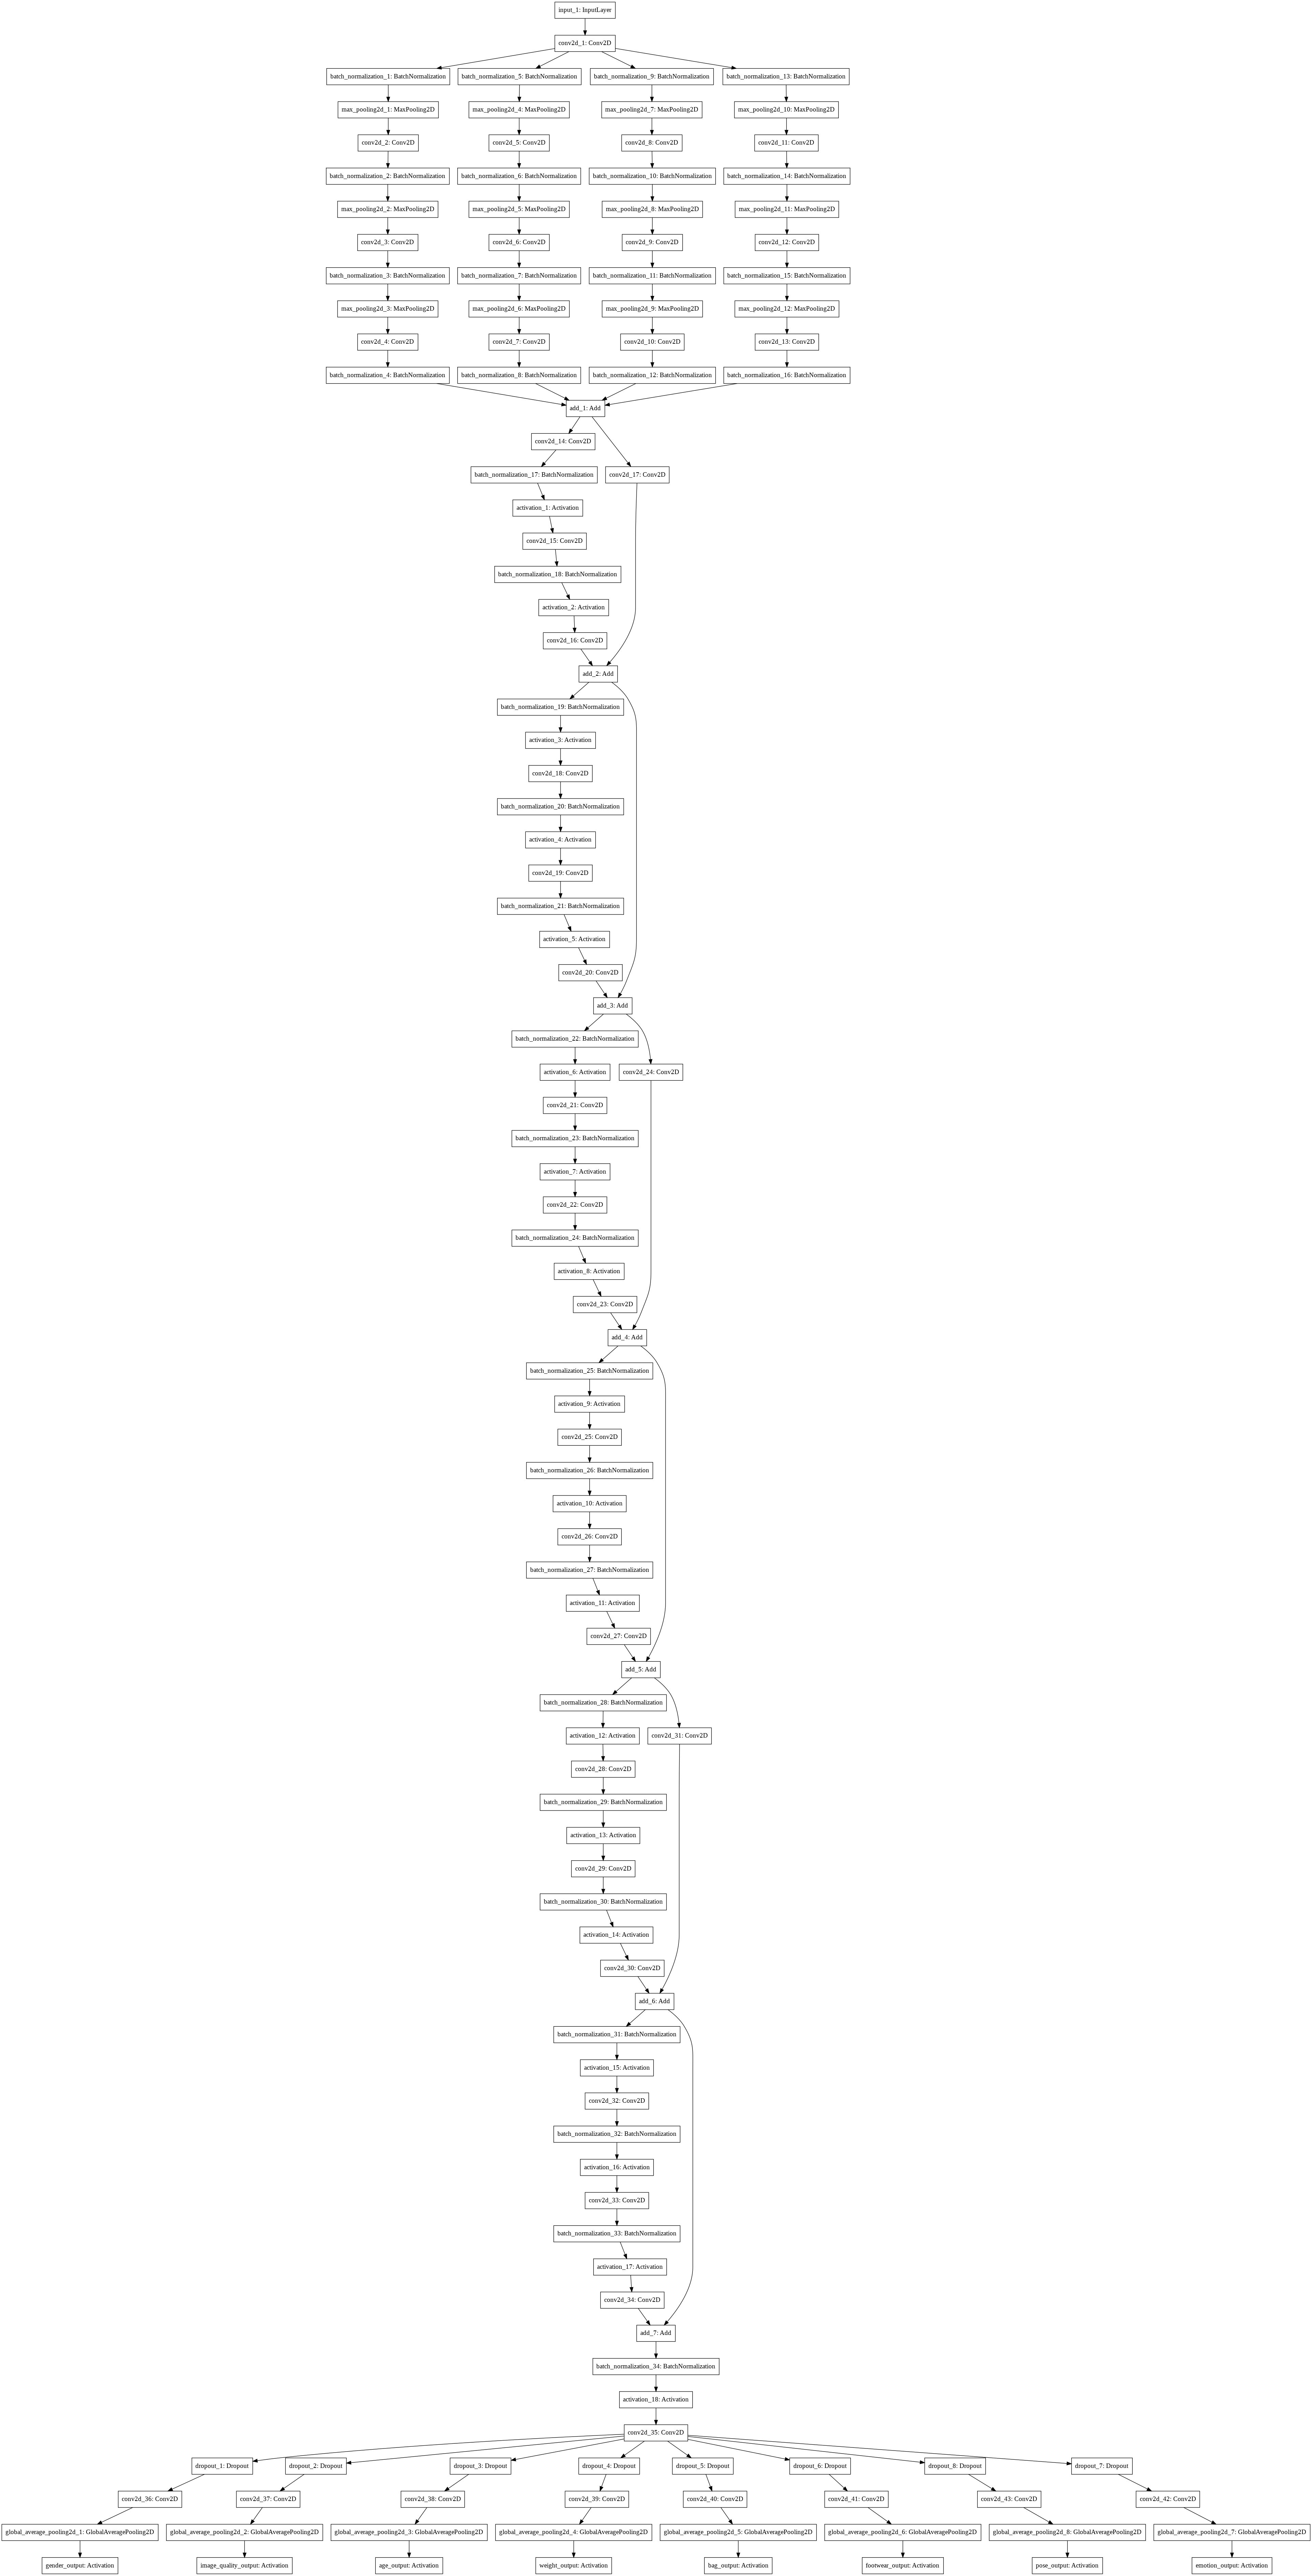

In [0]:
from keras.utils import plot_model
plot_model(model2)

In [0]:
model2.compile(loss=losses,
              optimizer=SGD(lr=0.005, momentum = 0.009),loss_weights=lossWeights,
              metrics=['accuracy'])
model2.summary()
#print(model_type)


'''
model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model2.summary()
print(model_type)

'''

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 224, 224, 16) 448         input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 224, 224, 16) 64          conv2d_44[0][0]            

"\nmodel2.compile(loss='categorical_crossentropy',\n              optimizer=Adam(lr=lr_schedule(0)),\n              metrics=['accuracy'])\nmodel2.summary()\nprint(model_type)\n\n"

In [0]:
lr_callback = LRFinder(num_samples=train_df.shape[0], batch_size=128,
                       minimum_lr=0.00002, maximum_lr=1.0,verbose=False,
                       lr_scale='exp', save_dir='./LR_LOGS/')


# Need to have the epochs = 1 here.
train_history = model2.fit_generator(train_gen,#   datagen.flow(x_train, 
                                              #   y_train, 
                                              #   batch_size = batch_size),
                                    #samples_per_epoch = x_train.shape[0], 
                                    epochs=1, 
                                    validation_data = valid_gen,# (x_test, y_test), 
                                    callbacks=[lr_callback],
                                    verbose=1)





Epoch 1/1
 18/360 [>.............................] - ETA: 1:21:48 - loss: 357.7190 - gender_output_loss: 0.6862 - image_quality_output_loss: 1.1829 - age_output_loss: 1.7691 - weight_output_loss: 1.1451 - bag_output_loss: 0.9905 - footwear_output_loss: 1.2415 - pose_output_loss: 1.0871 - emotion_output_loss: 1.3100 - gender_output_acc: 0.5764 - image_quality_output_acc: 0.1858 - age_output_acc: 0.0972 - weight_output_acc: 0.6354 - bag_output_acc: 0.6094 - footwear_output_acc: 0.3854 - pose_output_acc: 0.3472 - emotion_output_acc: 0.2726

KeyboardInterrupt: ignored

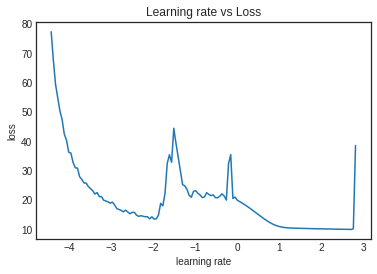

In [0]:

lr_callback.plot_schedule(clip_beginning=5)

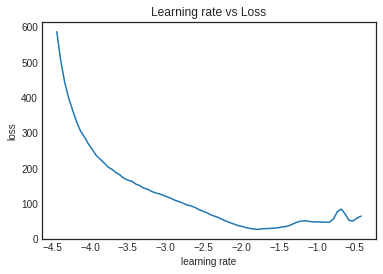

In [0]:
#best -1.9 ~ 0.0125
lr_callback.plot_schedule( clip_beginning = 5, clip_endding=10)

Save and Run Model


In [0]:
ckpt_callback = ModelCheckpoint(filepath='test_curr.h5', monitor='val_loss',save_best_only=True , save_weights_only=True, mode='auto',period=10)
lr_manager = OneCycleLR(samples=train_df.shape[0], epochs=10, batch_size=16,
                    steps=16, max_lr=0.0125,
                    end_percentage=0.1, scale_percentage=None,
                    maximum_momentum=None, minimum_momentum=None)

In [0]:
model2.compile(loss=losses,
              optimizer=SGD(lr=0.01, momentum = 0.009),loss_weights=lossWeights,
              metrics=['accuracy'])

In [0]:
model2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=10,
    verbose=1,callbacks=[ckpt_callback]
   # preprocessing_function=get_random_eraser(v_l=0, v_h=16),
)

Epoch 1/10
360/360 [==============================] - 90s 250ms/step - loss: 77.9199 - gender_output_loss: 0.3700 - image_quality_output_loss: 0.7819 - age_output_loss: 1.2439 - weight_output_loss: 0.8629 - bag_output_loss: 0.7506 - footwear_output_loss: 0.7017 - pose_output_loss: 0.4762 - emotion_output_loss: 0.7813 - gender_output_acc: 0.8344 - image_quality_output_acc: 0.6476 - age_output_acc: 0.4836 - weight_output_acc: 0.6641 - bag_output_acc: 0.6827 - footwear_output_acc: 0.6961 - pose_output_acc: 0.8133 - emotion_output_acc: 0.7225 - val_loss: 74.8528 - val_gender_output_loss: 0.4386 - val_image_quality_output_loss: 1.5354 - val_age_output_loss: 1.5011 - val_weight_output_loss: 0.9581 - val_bag_output_loss: 0.8697 - val_footwear_output_loss: 1.1410 - val_pose_output_loss: 0.5579 - val_emotion_output_loss: 0.8680 - val_gender_output_acc: 0.8006 - val_image_quality_output_acc: 0.3606 - val_age_output_acc: 0.4058 - val_weight_output_acc: 0.6275 - val_bag_output_acc: 0.6022 - val_fo

In [0]:
ckpt_callback = ModelCheckpoint(filepath='test_curr_1.h5', monitor='val_loss',save_best_only=True , save_weights_only=True, mode='auto',period=10)
lr_manager = OneCycleLR(samples=train_df.shape[0], epochs=10, batch_size=16,
                    steps=16, max_lr=0.0125,
                    end_percentage=0.1, scale_percentage=None,
                    maximum_momentum=None, minimum_momentum=None)

model2.load_weights('test_curr.h5')
model2.compile(loss=losses,
              optimizer=SGD(lr=0.005, momentum = 0.00009),loss_weights=lossWeights,
              metrics=['accuracy'])


model2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=10,
    verbose=1,callbacks=[ckpt_callback,lr_manager]
   # preprocessing_function=get_random_eraser(v_l=0, v_h=16),
)

Epoch 1/10
  3/360 [..............................] - ETA: 19:06 - loss: 24.0832 - gender_output_loss: 0.1690 - image_quality_output_loss: 0.3471 - age_output_loss: 0.3240 - weight_output_loss: 0.2469 - bag_output_loss: 0.2482 - footwear_output_loss: 0.2355 - pose_output_loss: 0.1228 - emotion_output_loss: 0.2968 - gender_output_acc: 0.9375 - image_quality_output_acc: 0.8542 - age_output_acc: 0.8854 - weight_output_acc: 0.9479 - bag_output_acc: 0.9271 - footwear_output_acc: 0.9167 - pose_output_acc: 0.9583 - emotion_output_acc: 0.8854

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.291614). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


360/360 [==============================] - 90s 250ms/step - loss: 22.7743 - gender_output_loss: 0.1033 - image_quality_output_loss: 0.2146 - age_output_loss: 0.2825 - weight_output_loss: 0.2031 - bag_output_loss: 0.1859 - footwear_output_loss: 0.1846 - pose_output_loss: 0.1178 - emotion_output_loss: 0.1927 - gender_output_acc: 0.9611 - image_quality_output_acc: 0.9215 - age_output_acc: 0.9033 - weight_output_acc: 0.9293 - bag_output_acc: 0.9323 - footwear_output_acc: 0.9352 - pose_output_acc: 0.9572 - emotion_output_acc: 0.9349 - val_loss: 33.1642 - val_gender_output_loss: 0.6344 - val_image_quality_output_loss: 1.8351 - val_age_output_loss: 2.2501 - val_weight_output_loss: 1.4536 - val_bag_output_loss: 1.7480 - val_footwear_output_loss: 2.0360 - val_pose_output_loss: 0.9723 - val_emotion_output_loss: 1.6210 - val_gender_output_acc: 0.7723 - val_image_quality_output_acc: 0.4097 - val_age_output_acc: 0.2837 - val_weight_output_acc: 0.5074 - val_bag_output_acc: 0.5868 - val_footwear_outp

In [0]:
from keras.models import load_model

model2.load_weights('test_curr_1.h5')
model2.compile(loss=losses,
              optimizer=SGD(lr=0.01, momentum = 0.009),loss_weights=lossWeights,
              metrics=['accuracy'])

results = model2.evaluate(valid_gen)
print(dict(zip(model2.metrics_names,results)))

63/63 [==============================] - 11s 181ms/step
{'loss': 44.73192493499271, 'gender_output_loss': 2.3900606215946256, 'image_quality_output_loss': 4.986669267926898, 'age_output_loss': 5.143558661142985, 'weight_output_loss': 4.180270444779169, 'bag_output_loss': 3.496041227900793, 'footwear_output_loss': 3.053635451528761, 'pose_output_loss': 1.987956200327192, 'emotion_output_loss': 7.335521660153828, 'gender_output_acc': 0.5942460317460317, 'image_quality_output_acc': 0.21329365079365079, 'age_output_acc': 0.13938492063492064, 'weight_output_acc': 0.4087301587301587, 'bag_output_acc': 0.5729166666666666, 'footwear_output_acc': 0.5416666666666666, 'pose_output_acc': 0.5853174603174603, 'emotion_output_acc': 0.09077380952380952}


In [0]:
ckpt_callback = ModelCheckpoint(filepath='test_curr_2.h5', monitor='val_loss',save_best_only=True , save_weights_only=True, mode= 'min',period=10)
lr_manager = OneCycleLR(samples=train_df.shape[0], epochs=10, batch_size=16,
                    steps=16, max_lr=0.0125,
                    end_percentage=0.1, scale_percentage=None,
                    maximum_momentum=None, minimum_momentum=None)

model2.load_weights('test_curr_1.h5')
model2.compile(loss=losses,
              optimizer=SGD(lr=0.005, momentum = 0.00009),loss_weights=lossWeights,
              metrics=['accuracy'])


model2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=20,
    verbose=1,callbacks=[ckpt_callback,lr_manager]
   # preprocessing_function=get_random_eraser(v_l=0, v_h=16),
)

Epoch 1/20
  3/360 [..............................] - ETA: 19:14 - loss: 14.5535 - gender_output_loss: 0.1412 - image_quality_output_loss: 0.3142 - age_output_loss: 0.5915 - weight_output_loss: 0.3974 - bag_output_loss: 0.2058 - footwear_output_loss: 0.3112 - pose_output_loss: 0.1787 - emotion_output_loss: 0.2558 - gender_output_acc: 0.9688 - image_quality_output_acc: 0.8438 - age_output_acc: 0.8438 - weight_output_acc: 0.8854 - bag_output_acc: 0.9271 - footwear_output_acc: 0.8958 - pose_output_acc: 0.9479 - emotion_output_acc: 0.9167

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.338999). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


360/360 [==============================] - 90s 249ms/step - loss: 13.4088 - gender_output_loss: 0.1145 - image_quality_output_loss: 0.2113 - age_output_loss: 0.2995 - weight_output_loss: 0.2071 - bag_output_loss: 0.2038 - footwear_output_loss: 0.1973 - pose_output_loss: 0.1285 - emotion_output_loss: 0.1903 - gender_output_acc: 0.9568 - image_quality_output_acc: 0.9200 - age_output_acc: 0.8936 - weight_output_acc: 0.9242 - bag_output_acc: 0.9213 - footwear_output_acc: 0.9265 - pose_output_acc: 0.9545 - emotion_output_acc: 0.9316 - val_loss: 27.0284 - val_gender_output_loss: 0.6822 - val_image_quality_output_loss: 2.0382 - val_age_output_loss: 3.4415 - val_weight_output_loss: 2.3756 - val_bag_output_loss: 1.4505 - val_footwear_output_loss: 1.7881 - val_pose_output_loss: 0.8971 - val_emotion_output_loss: 2.7562 - val_gender_output_acc: 0.7639 - val_image_quality_output_acc: 0.4861 - val_age_output_acc: 0.4018 - val_weight_output_acc: 0.6186 - val_bag_output_acc: 0.5516 - val_footwear_outp

In [0]:
from keras.models import load_model

model2.load_weights('test_curr_2.h5')
model2.compile(loss=losses,
              optimizer=SGD(lr=0.01, momentum = 0.009),loss_weights=lossWeights,
              metrics=['accuracy'])

results = model2.evaluate(valid_gen)
print(dict(zip(model2.metrics_names,results)))

63/63 [==============================] - 763s 12s/step
{'loss': 10.434503858051603, 'gender_output_loss': 0.18276735970247832, 'image_quality_output_loss': 0.3887781331108676, 'age_output_loss': 1.6311490403281317, 'weight_output_loss': 0.5153919111878152, 'bag_output_loss': 0.3425654869467493, 'footwear_output_loss': 0.3840886874804421, 'pose_output_loss': 0.19478214229826654, 'emotion_output_loss': 0.6200616593871798, 'gender_output_acc': 0.9399801587301587, 'image_quality_output_acc': 0.8933531746031746, 'age_output_acc': 0.5912698412698413, 'weight_output_acc': 0.8864087301587301, 'bag_output_acc': 0.9017857142857143, 'footwear_output_acc': 0.8903769841269841, 'pose_output_acc': 0.9370039682539683, 'emotion_output_acc': 0.8100198412698413}


# Run while data leak, Leads to higher accuracy

In [0]:
ckpt_callback = ModelCheckpoint(filepath='test_curr_3.h5', monitor='val_loss',save_best_only=True , save_weights_only=True, mode='auto',period=10)
lr_manager = OneCycleLR(samples=train_df.shape[0], epochs=10, batch_size=16,
                    steps=16, max_lr=0.0125,
                    end_percentage=0.1, scale_percentage=None,
                    maximum_momentum=None, minimum_momentum=None)

model2.load_weights('test_curr_2.h5')
model2.compile(loss=losses,
              optimizer=SGD(lr=0.0005, momentum = 0.0000009),loss_weights=lossWeights,
              metrics=['accuracy'])


model2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=30,
    verbose=1,callbacks=[ckpt_callback]
   # preprocessing_function=get_random_eraser(v_l=0, v_h=16),
)



Epoch 1/30
360/360 [==============================] - 752s 2s/step - loss: 8.4230 - gender_output_loss: 0.1554 - image_quality_output_loss: 0.3109 - age_output_loss: 0.4381 - weight_output_loss: 0.3188 - bag_output_loss: 0.2887 - footwear_output_loss: 0.2773 - pose_output_loss: 0.1724 - emotion_output_loss: 0.3071 - gender_output_acc: 0.9533 - image_quality_output_acc: 0.9027 - age_output_acc: 0.8747 - weight_output_acc: 0.9146 - bag_output_acc: 0.9160 - footwear_output_acc: 0.9193 - pose_output_acc: 0.9484 - emotion_output_acc: 0.9277 - val_loss: 8.3287 - val_gender_output_loss: 0.1391 - val_image_quality_output_loss: 0.2963 - val_age_output_loss: 0.4366 - val_weight_output_loss: 0.3066 - val_bag_output_loss: 0.2529 - val_footwear_output_loss: 0.3022 - val_pose_output_loss: 0.1690 - val_emotion_output_loss: 0.2925 - val_gender_output_acc: 0.9519 - val_image_quality_output_acc: 0.9048 - val_age_output_acc: 0.8795 - val_weight_output_acc: 0.9147 - val_bag_output_acc: 0.9187 - val_foot

In [0]:
from keras.models import load_model

model2.load_weights('test_curr_3.h5')
model2.compile(loss=losses,
              optimizer=SGD(lr=0.01, momentum = 0.009),loss_weights=lossWeights,
              metrics=['accuracy'])

results = model2.evaluate(valid_gen)
print(dict(zip(model2.metrics_names,results)))

63/63 [==============================] - 9s 149ms/step
{'loss': 7.637236595153809, 'gender_output_loss': 0.15459064949703002, 'image_quality_output_loss': 0.4040761701762676, 'age_output_loss': 0.5587317375318398, 'weight_output_loss': 0.3522960921557295, 'bag_output_loss': 0.3101986877450217, 'footwear_output_loss': 0.33766952922774685, 'pose_output_loss': 0.17122954716684208, 'emotion_output_loss': 0.3644447237593196, 'gender_output_acc': 0.9588293650793651, 'image_quality_output_acc': 0.9122023809523809, 'age_output_acc': 0.8844246031746031, 'weight_output_acc': 0.9241071428571429, 'bag_output_acc': 0.9236111111111112, 'footwear_output_acc': 0.9270833333333334, 'pose_output_acc': 0.9563492063492064, 'emotion_output_acc': 0.9305555555555556}


In [0]:
ckpt_callback = ModelCheckpoint(filepath='test_curr_3.h5', monitor='val_loss',save_best_only=True , save_weights_only=True, mode='auto',period=10)
lr_manager = OneCycleLR(samples=train_df.shape[0], epochs=10, batch_size=16,
                    steps=16, max_lr=0.0125,
                    end_percentage=0.1, scale_percentage=None,
                    maximum_momentum=None, minimum_momentum=None)

model2.load_weights('test_curr_2.h5')
model2.compile(loss=losses,
              optimizer=SGD(lr=0.0005, momentum = 0.0000009),loss_weights=lossWeights,
              metrics=['accuracy'])


model2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=30,
    verbose=1,callbacks=[ckpt_callback]
   # preprocessing_function=get_random_eraser(v_l=0, v_h=16),
)

Epoch 1/30
360/360 [==============================] - 94s 261ms/step - loss: 6.7170 - gender_output_loss: 0.0459 - image_quality_output_loss: 0.0766 - age_output_loss: 0.1050 - weight_output_loss: 0.0776 - bag_output_loss: 0.0724 - footwear_output_loss: 0.0702 - pose_output_loss: 0.0555 - emotion_output_loss: 0.0606 - gender_output_acc: 0.9852 - image_quality_output_acc: 0.9757 - age_output_acc: 0.9669 - weight_output_acc: 0.9750 - bag_output_acc: 0.9772 - footwear_output_acc: 0.9794 - pose_output_acc: 0.9824 - emotion_output_acc: 0.9826 - val_loss: 18.9771 - val_gender_output_loss: 0.7505 - val_image_quality_output_loss: 1.7450 - val_age_output_loss: 2.5951 - val_weight_output_loss: 1.8499 - val_bag_output_loss: 1.5528 - val_footwear_output_loss: 1.6431 - val_pose_output_loss: 0.8563 - val_emotion_output_loss: 1.8531 - val_gender_output_acc: 0.7753 - val_image_quality_output_acc: 0.4985 - val_age_output_acc: 0.3522 - val_weight_output_acc: 0.5625 - val_bag_output_acc: 0.5799 - val_foo

In [0]:
ckpt_callback = ModelCheckpoint(filepath='test_curr.h5', monitor='val_loss',save_best_only=True , save_weights_only=True, mode='auto',period=10)
lr_manager = OneCycleLR(samples=train_df.shape[0], epochs=10, batch_size=16,
                    steps=16, max_lr=0.0125,
                    end_percentage=0.1, scale_percentage=None,
                    maximum_momentum=None, minimum_momentum=None)

In [0]:
from keras.models import load_model
#weights.{epoch:02d}-{val_loss:.2f}.h5

model2.load_weights('temp_curr_1.h5')
#model = load_model('partly_trained.h5')
#model_curr = load_model('weights.10-91.53.h5')

In [0]:
model2.compile(loss=losses,
              optimizer=SGD(lr=0.01, momentum = 0.009),loss_weights=lossWeights,
              metrics=['accuracy'])
#model2.summary()

In [0]:
model2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=30,
    verbose=1,callbacks=[ckpt_callback]
   # preprocessing_function=get_random_eraser(v_l=0, v_h=16),
)

Epoch 1/30
360/360 [==============================] - 104s 289ms/step - loss: 288.0994 - gender_output_loss: 0.6531 - image_quality_output_loss: 0.9289 - age_output_loss: 1.4394 - weight_output_loss: 0.9915 - bag_output_loss: 0.9158 - footwear_output_loss: 0.9514 - pose_output_loss: 0.9157 - emotion_output_loss: 0.9160 - gender_output_acc: 0.6179 - image_quality_output_acc: 0.5527 - age_output_acc: 0.3882 - weight_output_acc: 0.6329 - bag_output_acc: 0.5581 - footwear_output_acc: 0.5604 - pose_output_acc: 0.6165 - emotion_output_acc: 0.7104 - val_loss: 268.0901 - val_gender_output_loss: 0.6591 - val_image_quality_output_loss: 0.9215 - val_age_output_loss: 1.4126 - val_weight_output_loss: 0.9922 - val_bag_output_loss: 0.8918 - val_footwear_output_loss: 0.9490 - val_pose_output_loss: 0.9040 - val_emotion_output_loss: 0.9032 - val_gender_output_acc: 0.6141 - val_image_quality_output_acc: 0.5600 - val_age_output_acc: 0.4038 - val_weight_output_acc: 0.6364 - val_bag_output_acc: 0.5694 - val

In [0]:
from keras.models import load_model

model2.load_weights('test_curr.h5')
model2.compile(loss=losses,
              optimizer=SGD(lr=0.01, momentum = 0.009),loss_weights=lossWeights,
              metrics=['accuracy'])

results = model2.evaluate(valid_gen)
print(dict(zip(model2.metrics_names,results)))

63/63 [==============================] - 12s 187ms/step
{'loss': 26.55498168582008, 'gender_output_loss': 0.7565779350106678, 'image_quality_output_loss': 2.058303780025906, 'age_output_loss': 3.090690616577391, 'weight_output_loss': 1.9115128271163455, 'bag_output_loss': 3.086181076746138, 'footwear_output_loss': 2.727973816886781, 'pose_output_loss': 1.0448831239389995, 'emotion_output_loss': 1.9557750963029408, 'gender_output_acc': 0.7346230158730159, 'image_quality_output_acc': 0.3958333333333333, 'age_output_acc': 0.25892857142857145, 'weight_output_acc': 0.46726190476190477, 'bag_output_acc': 0.5744047619047619, 'footwear_output_acc': 0.3715277777777778, 'pose_output_acc': 0.7078373015873016, 'emotion_output_acc': 0.5034722222222222}


In [0]:
ckpt_callback = ModelCheckpoint(filepath='test_curr_1.h5', monitor='val_loss',save_best_only=True , save_weights_only=True, mode='auto',period=10)
lr_manager = OneCycleLR(samples=train_df.shape[0], epochs=10, batch_size=16,
                    steps=16, max_lr=0.0125,
                    end_percentage=0.1, scale_percentage=None,
                    maximum_momentum=None, minimum_momentum=None)

model2.load_weights('test_curr.h5')
model2.compile(loss=losses,
              optimizer=SGD(lr=0.005, momentum = 0.00009),loss_weights=lossWeights,
              metrics=['accuracy'])


model2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,callbacks=[ckpt_callback]
   # preprocessing_function=get_random_eraser(v_l=0, v_h=16),
)

Epoch 1/50
360/360 [==============================] - 101s 282ms/step - loss: 10.2812 - gender_output_loss: 0.0559 - image_quality_output_loss: 0.0962 - age_output_loss: 0.1182 - weight_output_loss: 0.0924 - bag_output_loss: 0.0817 - footwear_output_loss: 0.0827 - pose_output_loss: 0.0583 - emotion_output_loss: 0.0756 - gender_output_acc: 0.9806 - image_quality_output_acc: 0.9657 - age_output_acc: 0.9615 - weight_output_acc: 0.9688 - bag_output_acc: 0.9744 - footwear_output_acc: 0.9724 - pose_output_acc: 0.9808 - emotion_output_acc: 0.9772 - val_loss: 24.5401 - val_gender_output_loss: 1.0360 - val_image_quality_output_loss: 1.9444 - val_age_output_loss: 3.3261 - val_weight_output_loss: 1.8070 - val_bag_output_loss: 1.9198 - val_footwear_output_loss: 1.8054 - val_pose_output_loss: 1.0373 - val_emotion_output_loss: 2.3437 - val_gender_output_acc: 0.7158 - val_image_quality_output_acc: 0.5392 - val_age_output_acc: 0.3750 - val_weight_output_acc: 0.5327 - val_bag_output_acc: 0.6042 - val_f

In [0]:
results = model2.evaluate(valid_gen)
print(dict(zip(model2.metrics_names,results)))

63/63 [==============================] - 8s 121ms/step
{'loss': 19.730398117549836, 'gender_output_loss': 0.29294300942666945, 'image_quality_output_loss': 0.47623238239496474, 'age_output_loss': 2.0786735424919733, 'weight_output_loss': 1.8288595037800925, 'bag_output_loss': 0.48266333294293234, 'footwear_output_loss': 0.6212138371571662, 'pose_output_loss': 0.21429175871705253, 'emotion_output_loss': 1.1704149056994726, 'gender_output_acc': 0.8908730158730159, 'image_quality_output_acc': 0.8665674603174603, 'age_output_acc': 0.6180555555555556, 'weight_output_acc': 0.7093253968253969, 'bag_output_acc': 0.8377976190476191, 'footwear_output_acc': 0.841765873015873, 'pose_output_acc': 0.9360119047619048, 'emotion_output_acc': 0.6567460317460317}


In [0]:
from keras.models import load_model

model2.load_weights('temp_curr_4.h5')
model2.compile(loss=losses,
              optimizer=SGD(lr=0.005, momentum = 0.009),loss_weights=lossWeights,
              metrics=['accuracy'])

results = model2.evaluate(valid_gen)
print(dict(zip(model2.metrics_names,results)))

63/63 [==============================] - 8s 129ms/step
{'loss': 3.1685615002162875, 'gender_output_loss': 0.025104161104421124, 'image_quality_output_loss': 0.027291489772150748, 'age_output_loss': 0.061538544645690495, 'weight_output_loss': 0.047837957563705645, 'bag_output_loss': 0.04387020724070247, 'footwear_output_loss': 0.033439659221570876, 'pose_output_loss': 0.02171594636110101, 'emotion_output_loss': 0.033711058326483155, 'gender_output_acc': 0.9945436507936508, 'image_quality_output_acc': 0.9935515873015873, 'age_output_acc': 0.9861111111111112, 'weight_output_acc': 0.9910714285714286, 'bag_output_acc': 0.9910714285714286, 'footwear_output_acc': 0.9920634920634921, 'pose_output_acc': 0.9935515873015873, 'emotion_output_acc': 0.9930555555555556}
